<a href="https://colab.research.google.com/github/Shorouk99/image_lassification_models/blob/main/CNN_Image_Classification_Using_PyTorch_Imagenette_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Classification Model Trained on Imagenette dataset using PyTorch
This model achieves accuracy of 70%  on testing data.
Building this network was guided by these tutorials ([1](https://www.analyticsvidhya.com/blog/2020/07/how-to-train-an-image-classification-model-in-pytorch-and-tensorflow/), [2](https://www.kaggle.com/vikasbhadoria/cifar10-high-accuracy-model-build-on-pytorch)).
Created on August 8, 2021 by Shorouk Magdy for the ARL Online Technical Mission

#Importing The dataset into the notebook
The section of code below downloades the Imagenette dataset and extracts it in Google Drive to be able to use it in Colab Notebook to benefit from the offered GPU

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=5bc6ac5027a655b75498952b27fdc358dbf5369b46effbcbb25e4766ac86c162
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget
url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz'
dest = '/content/drive/My Drive/imagenette2-160.tgz'

wget.download(url, out=dest)

'/content/drive/My Drive/imagenette2-160.tgz'

In [ ]:
import tarfile

file = tarfile.open('/content/drive/My Drive/imagenette2-160.tgz')
file.extractall('/content/drive/My Drive')
file.close()

#Loading the dataset and applying needed transforms

In [ ]:
# importing the packages
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [ ]:
# Creating transform objects for the training and testing data 
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5) , (0.5, 0.5, 0.5)),
                              transforms.Resize((160,160))
                              ])
transform_train = transforms.Compose([transforms.Resize((160,160)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])


In [ ]:
# Loading the data and applying the transforms
train_data = datasets.ImageFolder('/content/drive/MyDrive/imagenette2-160/train', transform=transform_train)
test_data = datasets.ImageFolder('/content/drive/MyDrive/imagenette2-160/val', transform=transform)

# Creating the Dataloader objects that put the data into iterable batches for the modeling process
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

In [ ]:
# Checking data dimesions
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([128, 3, 160, 160])
torch.Size([128])


#Building a VGG architecture
I used a -relatively shallow- VGG architecture to train this image classification model. The network consists of 4 blocks of (Conv > ReLU > MaxPool > Dropout) followed by 3 fully connected layers

In [ ]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.35),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(32*10*10, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.35),
            nn.Linear(4096, 10),
        )
    
    
    def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x

#Training and testing the Network

In [ ]:
# Defining the model
model = vgg()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

vgg(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.35, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_fe

In [ ]:
# Training the model
loss_history = []
for i in range(85):
    running_loss = 0
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.cuda()
          labels = labels.cuda()

        # Clearing old gradients and forward propagating
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        # Backprobagating and updating the parameters
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))
        loss_history.append(running_loss/len(trainloader))

Epoch 1 - Training loss: 2.3008635688472436
Epoch 2 - Training loss: 2.2421989602011605
Epoch 3 - Training loss: 2.0731731620994776
Epoch 4 - Training loss: 1.9734526872634888
Epoch 5 - Training loss: 1.900587750447763
Epoch 6 - Training loss: 1.8502421137448903
Epoch 7 - Training loss: 1.7830083515193011
Epoch 8 - Training loss: 1.7382576997215684
Epoch 9 - Training loss: 1.6903400856095392
Epoch 10 - Training loss: 1.650170381004746
Epoch 11 - Training loss: 1.639424876586811
Epoch 12 - Training loss: 1.5619675629847758
Epoch 13 - Training loss: 1.497915122960065
Epoch 14 - Training loss: 1.468146589962212
Epoch 15 - Training loss: 1.4081841610573433
Epoch 16 - Training loss: 1.3621753421989646
Epoch 17 - Training loss: 1.3317150280282304
Epoch 18 - Training loss: 1.3185561315433398
Epoch 19 - Training loss: 1.269995297934558
Epoch 20 - Training loss: 1.2426273645581425
Epoch 21 - Training loss: 1.2254016487985044
Epoch 22 - Training loss: 1.1885998949811265
Epoch 23 - Training loss:

In [ ]:
# getting predictions on test set and measuring the performance
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
    img = images[i].view(1, 3, 160, 160)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.cpu()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print(f"\nModel Accuracy ={(correct_count/all_count):.2f}")

Number Of Images Tested = 3925

Model Accuracy =0.71


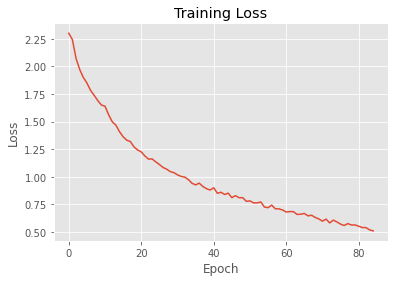

In [ ]:
# Plotting the learning curve
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0,85), loss_history, label='Training loss')
plt.xlabel ('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()